# Fast Fourier Tranform Denoising
In this kernel I will show a quick trick to denoise your signal.

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import matplotlib.pyplot as plt
import matplotlib.style as style 
style.use('ggplot')

import os
print(os.listdir("../Denoise Alogrithm/Input/FFT"))

['sample_submission.csv', 'X_test.csv', 'X_train.csv', 'y_train.csv']


In [10]:
# Load data
INPUT_DIR = '../Denoise Alogrithm/Input/FFT'

X_train = pd.read_csv(f'{INPUT_DIR}/X_train.csv')
X_test = pd.read_csv(f'{INPUT_DIR}/X_test.csv')
target = pd.read_csv(f'{INPUT_DIR}/y_train.csv')

As you may already know, in this competition we are given 128 measurements per time series from 10 sensor channels. Let's take a closer look:

In [11]:
series_dict = {}
for series in (X_train['series_id'].unique()):
    series_dict[series] = X_train[X_train['series_id'] == series] 

In [12]:
# From: Code Snippet For Visualizing Series Id by @shaz13
def plotSeries(series_id):
    style.use('ggplot')
    plt.figure(figsize=(28, 16))
    print(target[target['series_id'] == series_id]['surface'].values[0].title())
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        if col.startswith("o"):
            color = 'red'
        elif col.startswith("a"):
            color = 'green'
        else:
            color = 'blue'
        if i >= 7:
            i+=1
        plt.subplot(3, 4, i + 1)
        plt.plot(series_dict[series_id][col], color=color, linewidth=3)
        plt.title(col)

Concrete


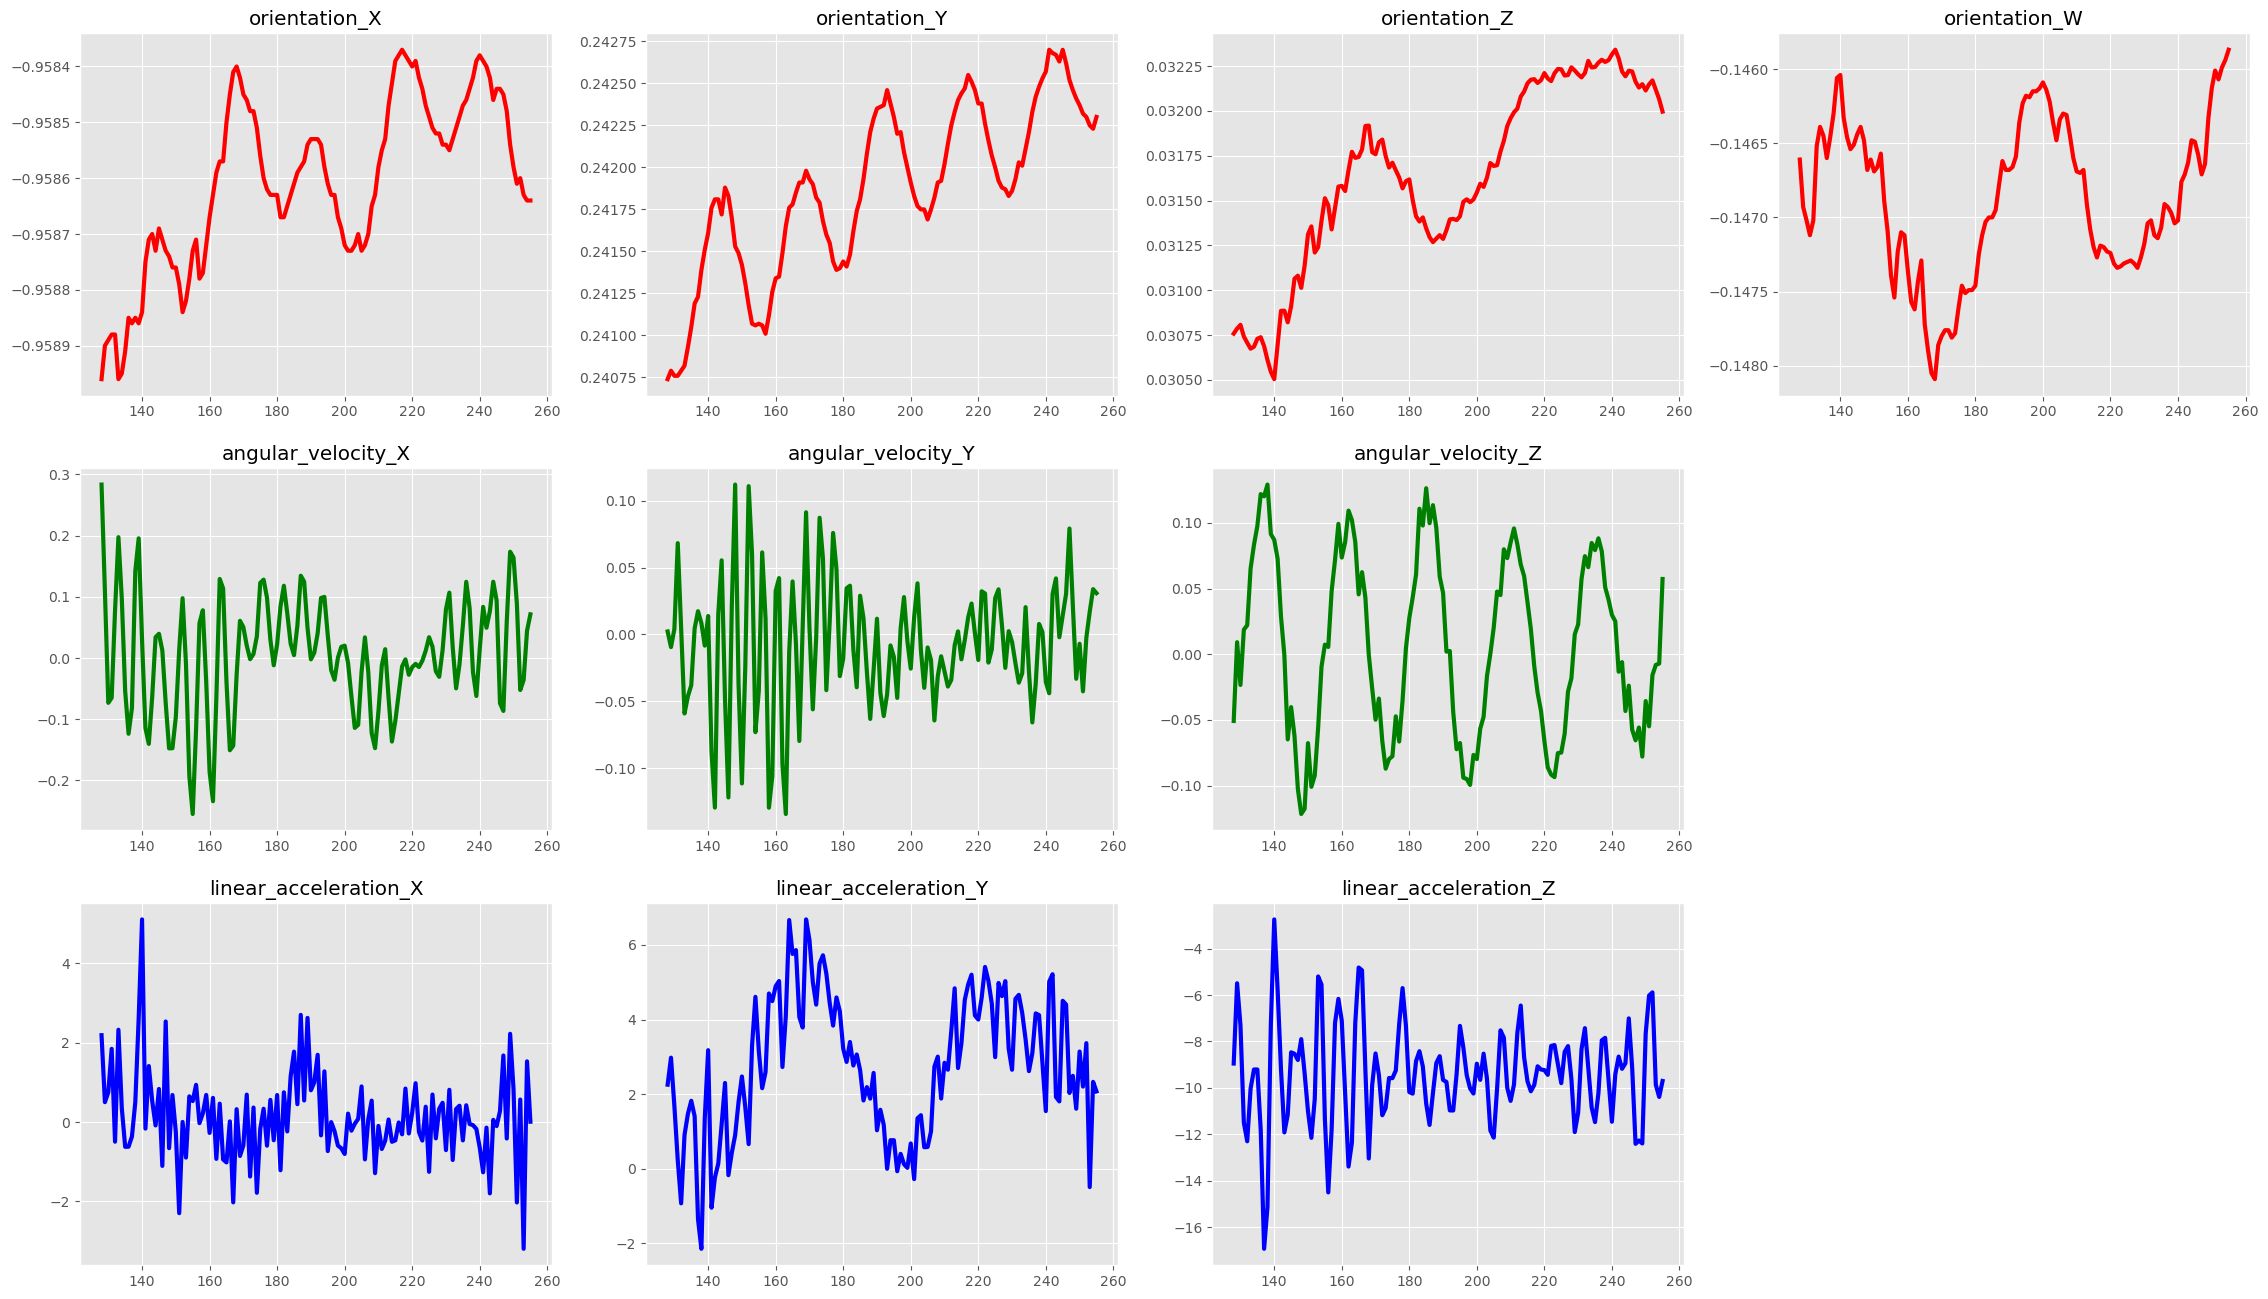

In [13]:
plotSeries(1)

If for whatever reason you want to denoise the signal, you can use fast fourier transform. Detailed implementation of how it's done is out of the scope of this kernel. You can learn more about it here: https://en.wikipedia.org/wiki/Fast_Fourier_transform

In [14]:
# from @theoviel at https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

Let's say that I want to denoise the signal on angular_velocity and linear_acceleration column

In [15]:
# denoise train and test angular_velocity and linear_acceleration data
X_train_denoised = X_train.copy()
X_test_denoised = X_test.copy()

# train
for col in X_train.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        # Apply filter_signal function to the data in each series
        denoised_data = X_train.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))
        
        # Assign the denoised data back to X_train
        list_denoised_data = []
        for arr in denoised_data:
            for val in arr:
                list_denoised_data.append(val)
                
        X_train_denoised[col] = list_denoised_data
        
# test
for col in X_test.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        # Apply filter_signal function to the data in each series
        denoised_data = X_test.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))
        
        # Assign the denoised data back to X_train
        list_denoised_data = []
        for arr in denoised_data:
            for val in arr:
                list_denoised_data.append(val)
                
        X_test_denoised[col] = list_denoised_data
        

Now, let's look at the result:

In [16]:
series_dict = {}
for series in (X_train_denoised['series_id'].unique()):
    series_dict[series] = X_train_denoised[X_train_denoised['series_id'] == series] 

Concrete


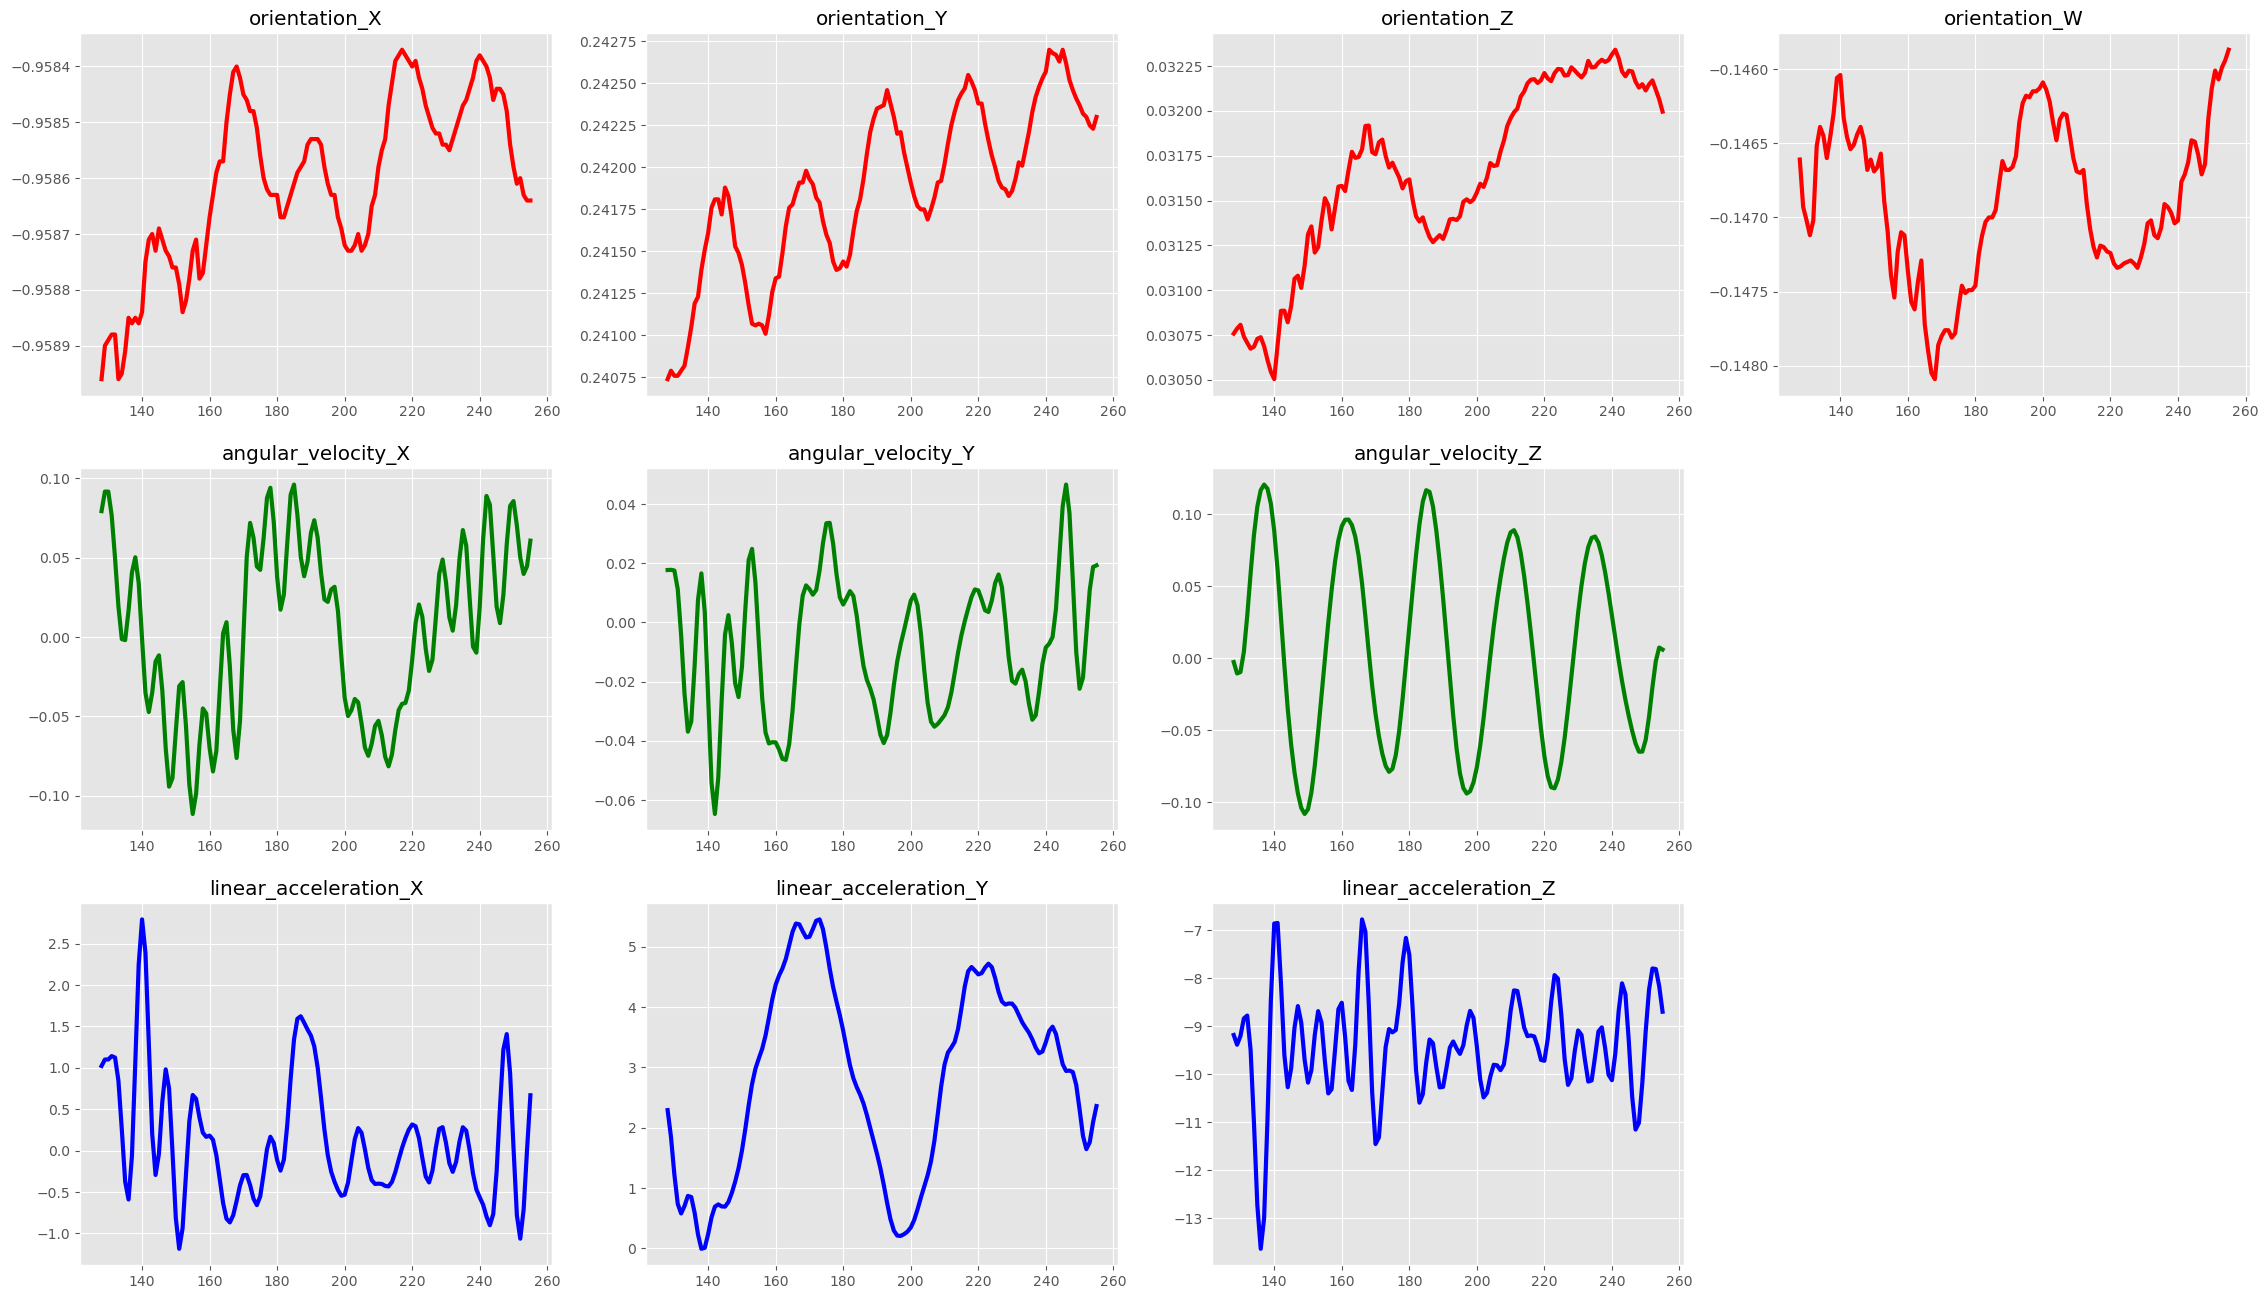

In [17]:
plotSeries(1)

As you can see, our signal become much smoother than before. Here's a closer comparison:

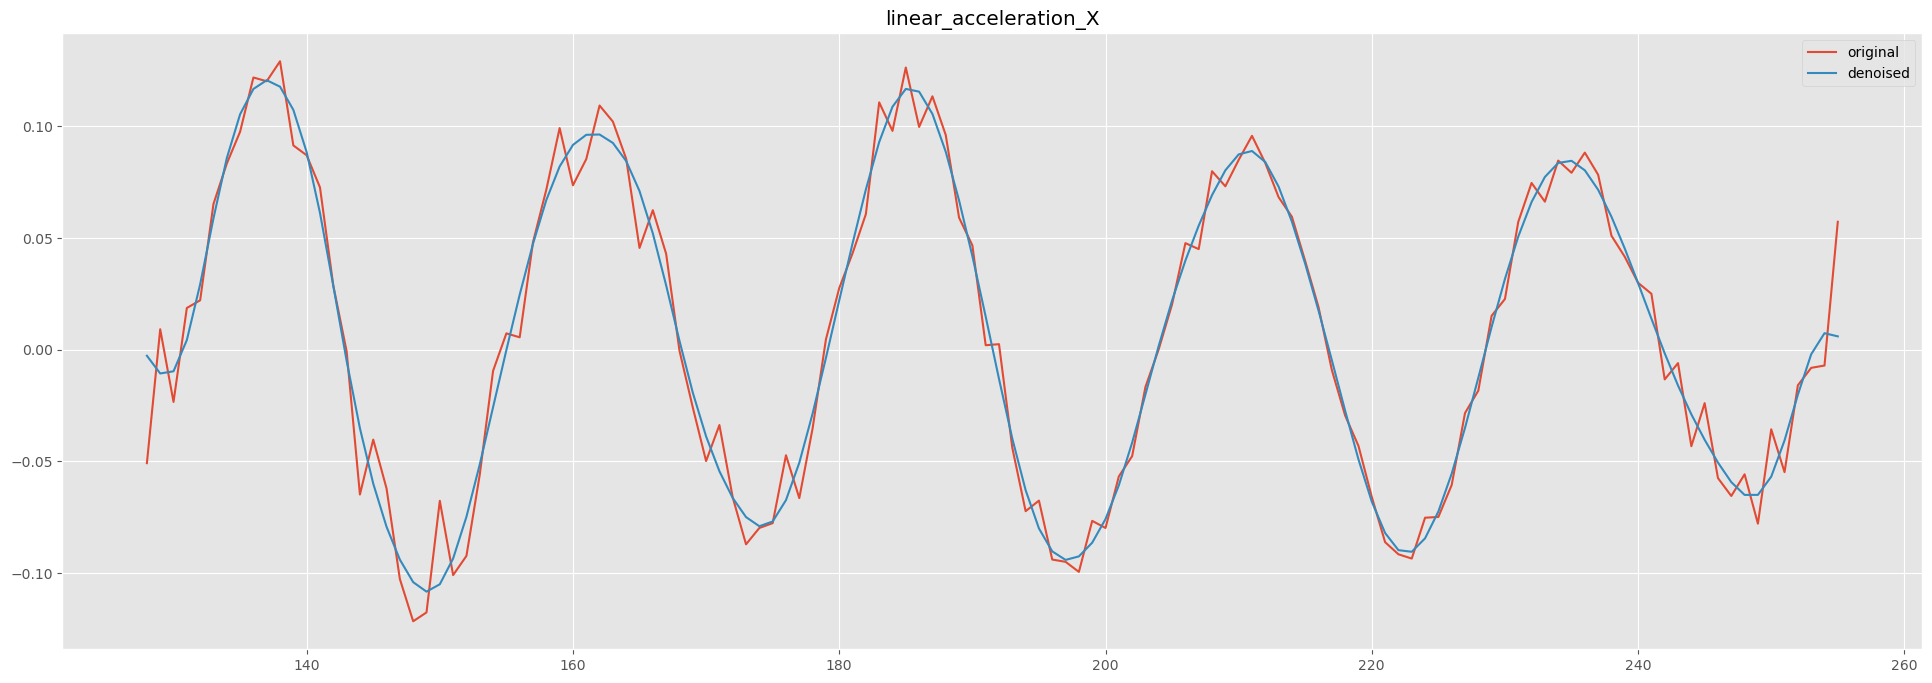

In [18]:
plt.figure(figsize=(24, 8))
plt.title('linear_acceleration_X')
plt.plot(X_train.angular_velocity_Z[128:256], label="original");
plt.plot(X_train_denoised.angular_velocity_Z[128:256], label="denoised");
plt.legend()
plt.show()

Thank you for reading my first kernel. I hope this kernel can be usefull for your competition!

In [19]:
X_test.to_csv('../Denoise Alogrithm/FFT results/X_test_denoised.csv', index=False)
X_train.to_csv('../Denoise Alogrithm/FFT results/X_train_denoised.csv', index=False)